# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [31]:

import numpy as np
from time import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer
import re, string
from nltk.corpus import stopwords

In [2]:
# Reading the dataset with no columns titles and with latin encoding 
df_raw = pd.read_csv('df.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["label", "time", "date", "query", "username", "text"]

# Show the first 5 rows of the dataframe.
# You can specify the number of rows to be shown as follows: df_raw.head(10)
df_raw.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Checking the data's output balance
# The label '4' denotes positive sentiment and '0' denotes negative sentiment
df_raw['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

In [4]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['label', 'text']]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


\*\* *Feel free to skip this step if you're working with a powerful machine, or have lots (and I mean lots) of time to spare* 😅 \*\*  
As our data is huge (1,600,000 rows), working with it on a regular machine is very challenging. For this reason, we will trim our dataframe to $\frac{1}{4} $th of its original size.  
As data output balance is key for a better performing algorithm, we will make sure to maintain the data balance while trimming the dataframe.

In [5]:
# Seperating positive and negative rows
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [6]:
# Only retaining 1/4th of our data from each output group
# Feel free to alter the dividing factor depending on your workspace
# 1/64 is a good place to start if you're unsure about your machine's power
df_pos = df_pos.iloc[:int(len(df_pos)/4)]
df_neg = df_neg.iloc[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [7]:
# Concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

400000

In [8]:
start_time = time()


# The redule_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['label'].tolist()

#Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 102.73312711715698


[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'],
  1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'Cant',
   'wait',
   '!',
   '!',
   '-',
   'GIRL',
   'TALK',
   '!',
   '!'],
  1),
 (['@DaRealSunisaKim',
   'Thanks',
   'for',
   'the',
   'Twitter',
   'add',
   ',',
   'Sunisa',
   '!',
   'I',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'HIN',
   'show',
   'here',
   'in',
   'the',
   'DC',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['Being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'Plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

In [9]:

# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mozzietian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mozzietian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['I', 'LOVE', '@Health4UandPets', 'u', 'guy', 'r', 'the', 'best', '!', '!']


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>

In [11]:

STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['love', 'guy', 'best']


In [12]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that tranforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input strucutre of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
    
print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]

Removed Noise, CPU Time: 1062.680771112442
Data Prepared for model, CPU Time: 3.2775118350982666


[({'love': True, 'guy': True, 'best': True}, 1),
 ({'meet': True,
   'one': True,
   'besties': True,
   'tonight': True,
   'cant': True,
   'wait': True,
   'girl': True,
   'talk': True},
  1),
 ({'thanks': True,
   'twitter': True,
   'add': True,
   'sunisa': True,
   'get': True,
   'meet': True,
   'hin': True,
   'show': True,
   'area': True,
   'sweetheart': True},
  1),
 ({'sick': True,
   'really': True,
   'cheap': True,
   'hurt': True,
   'much': True,
   'eat': True,
   'real': True,
   'food': True,
   'plus': True,
   'friend': True,
   'make': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

In [14]:


# As our data is currently ordered by label, we have to shuffle it before splitting it
# .Random(140) randomizes our data with seed = 140. This guarantees the same shuffling for every execution of our code
# Feel free to alter this value or even omit it to have different outputs for each code execution
random.Random(140).shuffle(final_data)

# Here we decided to split our data as 90% train data and 10% test data
# Once again, feel free to alter this number and test the model accuracy
trim_index = int(len(final_data) * 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

### 5.1.2. Global Vectors for Word Representation (GloVe) <a class="anchor" id="head-5-1-2"></a>

zsh:1: command not found: wget
unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


GloVe embeddings come in various flavors. They basically differ depending on the type of data they were trained on, the length of the vocabulary, the size of the representational vectors and so on.

We've previously downloaded GloVe vectors trained on 6 Billion tokens and having a dictionary, or *vocabulary*, size of 400,001 unique words. Believe it or not, this is the smallest model from GloVe! Next we will load the vectors that are 50-dimensional.

In [16]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [19]:

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [23]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [24]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['tomato'])

0.8632714714841137

In [25]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.012485506721235957

## 5.2. Data Transformation <a class="anchor" id="head-5-2"></a>

In [30]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

        
# Here we will utilize the already computed 'cleaned_tokens_list' variable
   
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    


max_len: 25


## 5.3. Building the Model <a class="anchor" id="head-5-3"></a>

In [28]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [29]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output betwene 0 and 1.

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [32]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [34]:
len(X_train)

320000

In [35]:
len(X_test)

80000

## 5.4. Training the Model <a class="anchor" id="head-5-4"></a>

In [37]:
# Setting a batch size of 20 and training our model for 20 epochs

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 8, batch_size = 128, shuffle=True)

Epoch 1/8
2500/2500 [==============================] - 582s 233ms/step - loss: 0.5341 - accuracy: 0.7269 - val_loss: 0.5134 - val_accuracy: 0.7419
Epoch 2/8
2500/2500 [==============================] - 581s 232ms/step - loss: 0.5031 - accuracy: 0.7492 - val_loss: 0.4991 - val_accuracy: 0.7521
Epoch 3/8
2500/2500 [==============================] - 577s 231ms/step - loss: 0.4829 - accuracy: 0.7629 - val_loss: 0.4897 - val_accuracy: 0.7599
Epoch 4/8
2500/2500 [==============================] - 594s 238ms/step - loss: 0.4644 - accuracy: 0.7745 - val_loss: 0.4887 - val_accuracy: 0.7585
Epoch 5/8
2500/2500 [==============================] - 584s 234ms/step - loss: 0.4451 - accuracy: 0.7862 - val_loss: 0.4873 - val_accuracy: 0.7641
Epoch 6/8
2500/2500 [==============================] - 564s 226ms/step - loss: 0.4224 - accuracy: 0.7993 - val_loss: 0.4899 - val_accuracy: 0.7630
Epoch 7/8
2500/2500 [==============================] - 579s 231ms/step - loss: 0.3944 - accuracy: 0.8151 - val_loss: 0

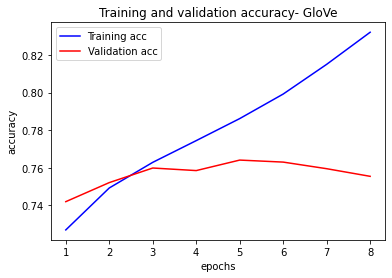

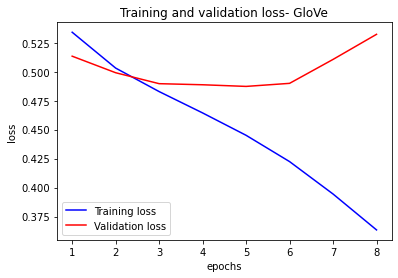

In [48]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy- GloVe')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss- GloVe')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
 
plt.show()